# Volume 4: Poisson's Equation
    <Name>
    <Class>
    <Date>

In [18]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import imageio
from scipy.sparse import spdiags, csr_matrix, diags, block_diag

# Problem 1

Complete the function `poisson_square` by implementing the finite difference method given in the lab. Use `scipy.sparse.linalg.spsolve` to solve the linear system. Use your function to solve the boundary value problem:

\begin{align}
	\Delta u = 0, &{}\quad x \in [0,1]\times [0,1],\\
	u(x,y) = x^3, &{}\quad (x,y) \in \partial ([0,1]\times [0,1])
\end{align}

Use $n=100$ subintervals for both $x$ and $y$. Plot the solution as a 3D surface.

In [21]:
def poisson_square(a,b,c,d,f,g,n):
    """Computes the finite difference method for the Poisson equation boundary-value
    problem on a square:
        
        u_xx + u_yy = f on R = [a,b]×[c,d]
        u = g on ∂R
    
    where (b-a) = (d-c).
        
    Parameters:
        a (float): left-hand boundary for x
        b (float): right-hand boundary for x
        c (float): lower boundary for y
        d (float): uppder boundary for y
        f (function): right-hand side of the PDE
        g (function): boundary condition
        n (int): number of subintervals
    Returns:
        U (ndarray of shape (n+1,n+1)): approximate solution
    """
    
    # Define distance between different points
    h = (b-a)/n
    
    # Sub-diagonal of T
    sub_diagonal = np.array([1 for i in range(0,n-1)])
    
    # Middle Diagonal of T
    middle_diagonal = np.array([-4 for i in range(0,n)])
    
    # Create diagonals and offsets
    diagonals = [sub_diagonal, middle_diagonal, sub_diagonal]
    offsets = [-1,0,1]
     
    # Make T
    T = diags(diagonals, offsets, shape = (n-1, n-1))
    
    # Make A
    A = block_diag([T]*(n-1))
    A.setdiag(1, k = -T.shape[0])
    A.setdiag(1,k = T.shape[0])
    A = 1/h**2 * A
    
    # Define X and Y
    X = np.linspace(a,b,n+1)
    Y = np.linspace(c,d,n+1)
    
    # Make the array p
    p = []
    for j in range (1,n):
        p_temp = [g(a,Y[j])] + [0 for i in range(2,n-1)] + [g(b, Y[j])]
        p.append(p_temp)
    p = 1/h**2 * np.array(sum(p, []))
    
    # Make the array q
    q1 = 1/h**2 * np.array([g(X[i], c) for i in range(1,n)])
    q_last = 1/h**2 * np.array([g(X[i], d) for i in range(1,n)])
    q_middle = []
    for j in range(2,n-1):
        q_middle = np.zeros((n-1) * (n-3))
    q = np.concatenate((q1, q_middle, q_last))
    
    
    # Create f_array
    f_array = np.zeros((n - 1)**2)
    for j in range(1, n):
        for i in range(1, n):
            f_array[(j - 1) * (n - 1) + (i - 1)] = f(X[i], Y[j])

    # Create right side of equation
    right_side = f_array - p - q
    
    # Solve for U
    U = sp.linalg.spsolve(A.tocsc(), right_side)
    U = U.reshape(n-1, n-1)
    
    return X,Y,U


    

    

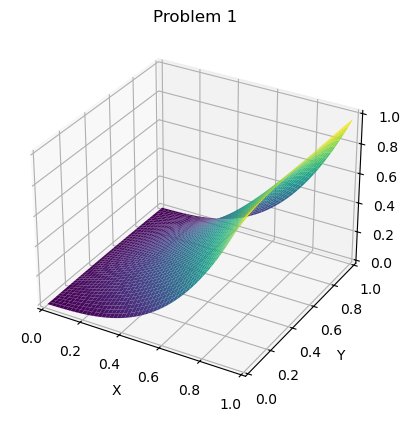

In [22]:
# Set conditions for this example
a = 0
b = 1
c = 0
d = 1
f = lambda x,y: 0
g = lambda x,y: x**3
n = 100

# Call function
X, Y, U = poisson_square(a,b,c,d,f,g,n)

# Create figure object
fig = plt.figure()

# Create 3D axis object using add_subplot()
ax = fig.add_subplot(111, projection = '3d')

# Make meshgrid of X, Y
X,Y = np.meshgrid(X,Y)

# Plot surface 
ax.plot_surface(X[1:-1, 1:-1],Y[1:-1, 1:-1],U, cmap = 'viridis')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Problem 1")
plt.show()
    



# Problem 2

Solve 

\begin{align}
	\Delta V = -\rho(x,y), &{}\quad x \in [-2,2]\times [-2,2],\\
	u(x,y) = 0, &{}\quad (x,y) \in \partial ([-2,2]\times [-2,2]).
\end{align}

for the electric potential $V.$ Use the source function defined above, such that $\rho(x,y) = \text{source}(x,y)$. Use $n=100$ subintervals for $x$ and $y$. Use the provided code to plot your solution.

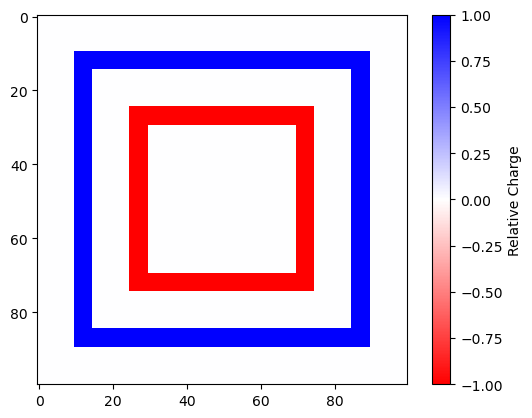

In [23]:
import matplotlib.colors as mcolors

def source(X,Y):
    """
    Takes arbitrary arrays of coordinates X and Y and returns an array of the same shape
    representing the charge density of nested charged squares
    """
    src = np.zeros(X.shape)
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-1.5) < .1,abs(X+1.5) < .1) ,abs(Y) <  1.6),
    np.logical_and( np.logical_or(abs(Y-1.5) < .1,abs(Y+1.5) < .1) ,abs(X) <  1.6))] = 1
    
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-0.9) < .1,abs(X+0.9) < .1) ,abs(Y) <  1.0),
    np.logical_and( np.logical_or(abs(Y-0.9) < .1,abs(Y+0.9) < .1) ,abs(X) <  1.0))] = -1
    return src
    
#Generate a color dictionary for use with LinearSegmentedColormap
#that places red and blue at the min and max values of data
#and white when data is zero
def genDict(data):
    zero = 1/(1 - np.max(data)/np.min(data))
    cdict = {
    'red': [(0.0, 1.0, 1.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'green': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'blue': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 1.0, 1.0)]
    }
    return cdict

# Set conditions for this example
a1 = -2.
b1 = 2.
c1 = -2.
d1 = 2.
n =100
X = np.linspace(a1,b1,n)
Y = np.linspace(c1,d1,n)
X,Y = np.meshgrid(X,Y)

# Plot Problem 2 - Part 1
plt.imshow(source(X,Y),cmap = mcolors.LinearSegmentedColormap('cmap', genDict(source(X,Y))))
plt.colorbar(label="Relative Charge")
plt.show()

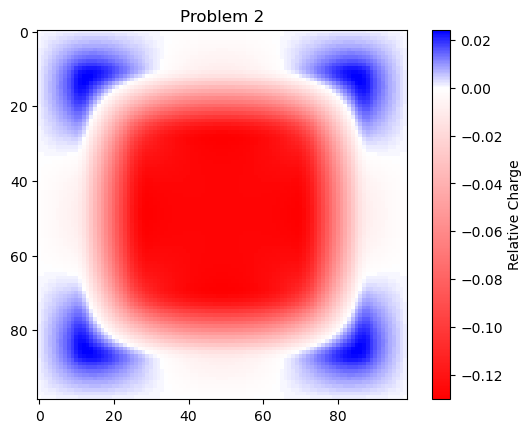

In [24]:
# Set conditions for problem 
a = -2
b = 2
c = -2
d = 2
f = lambda x,y: -source(x,y)
g = lambda x,y: 0
n = 100

# Call function
X, Y, U = poisson_square(a,b,c,d,f,g,n)
X,Y = np.meshgrid(X,Y)

# Plot Problem 2 - Part 2
plt.imshow(U,cmap = mcolors.LinearSegmentedColormap('cmap', genDict(U)))
plt.colorbar(label="Relative Charge")
plt.title('Problem 2')
plt.show()





# Problem 3
Using the data file dr_jarvis.jpg as the source image $v$ and mount_rushmore.jpg as the destination image $u_0$, put Dr. Jarvis' face on Mount Rushmore. Use the finite difference Laplacian operator to calculate $f$ from $v$ .

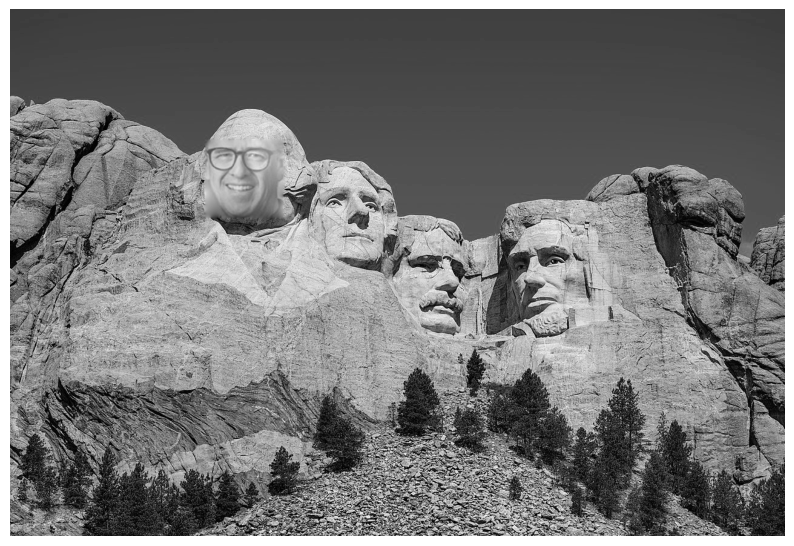

In [25]:
source = np.mean(imageio.v3.imread('dr_jarvis.jpg'), axis=2).transpose() /255
dest = np.mean(imageio.v3.imread('mount_rushmore.jpg'), axis=2).transpose() / 255

w = 130 # width and height to crop out.
x0s = 60 # position in source image
y0s = 84
x0 = 322 # position in destination image
y0 = 215
image = source[x0s-1:x0s+w+1,y0s-1:y0s+w+1]*0.58    # source image with a buffer of 1 pixel for the finite difference method.
                                                    # The buffer will need to be removed before inserting into the Mount
                                                    # Rushmore image. The '*0.58' will make it look better when displayed


# Sub-diagonal of T
sub_diagonal = np.ones(w-1)

# Middle Diagonal of T
middle_diagonal = -4 * np.ones(w)

# Create diagonals and offsets
diagonals = [sub_diagonal, middle_diagonal, sub_diagonal]
offsets = [-1,0,1]
    
# Make T
T = diags(diagonals, offsets, shape = (w, w)).toarray()

# Make A
A = block_diag([T]*(w))
A.setdiag(1, k = -T.shape[0])
A.setdiag(1,k = T.shape[0])
A = A.tocsr()

# Create f to solve
center_image = image[1:-1,1:-1]
left_image = image[1:-1,2:]
right_image = image[1:-1,:-2]
up_image = image[:-2,1:-1]
down_image = image[2:,1:-1]

# Calculate the f_vec
f_vec = left_image + right_image + up_image + down_image - 4*center_image
f_vec[0,:] -= dest[x0-1,y0:y0+w]
f_vec[-1:,:] -= dest[x0+w,y0:y0+w]
f_vec[:,0] -= dest[x0:x0+w,y0-1]
f_vec[:,-1] -= dest[x0:x0+w,y0+w]

# Solve for U
U = np.zeros((w,w))
U = np.reshape(sp.linalg.spsolve(A, f_vec.flatten()), (w,w))

# Show Dr. Jarvis on Mount Rushmore
new_image = dest.copy()
new_image[x0:x0+w,y0:y0+w] = U.reshape(w,w)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(new_image.transpose(), cmap = 'gray')
plt.show()
